1. Preparação e limpeza dos dados

In [309]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL


In [310]:
# Carrega os dados
PATH = r'C:\Users\luizz\Documents\GitHub\portfolio\coffee-series-models\data\raw\coffee_word_bank.xlsx'
df = pd.read_excel(PATH)

df

,date,price
0,1960-01-01,0.940900
1,1960-02-01,0.946900
2,1960-03-01,0.928100
3,1960-04-01,0.930300
4,1960-05-01,0.920000
...,...,...
774,2024-07-01,5.668078
775,2024-08-01,5.763759
776,2024-09-01,6.124655
777,2024-10-01,6.101727


In [311]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

2. Análise exploratória

In [312]:
def basics_estatistics(df):
    """
    Retorna estatísticas básicas do dataframe
    """
    print(f"{df['price'].describe()}\n")
    print(f"Number of null values: {df['price'].isnull().sum()}\n")
    print(df.info())
    
    return 

basics_estatistics(df)     

count    779.000000
mean       2.647307
std        1.388668
min        0.777600
25%        1.375468
50%        2.735700
75%        3.414515
max        7.003600
Name: price, dtype: float64

Number of null values: 0

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 779 entries, 1960-01-01 to 2024-11-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   779 non-null    float64
dtypes: float64(1)
memory usage: 12.2 KB
None


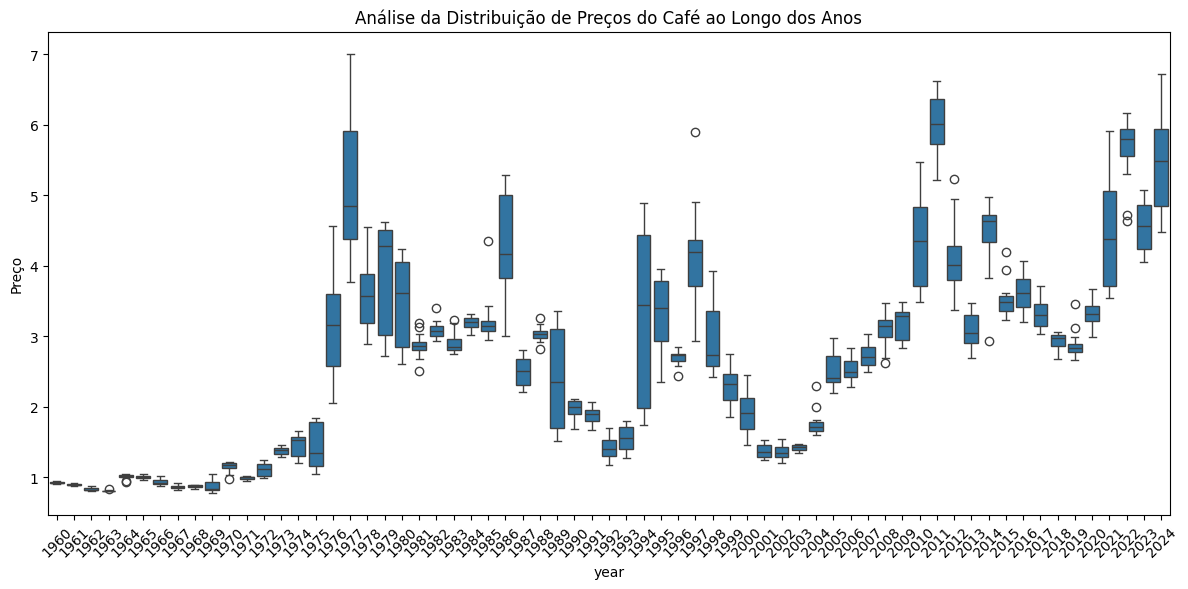

In [313]:
# Distribuição de Preços do Café por Ano
df['year'] = df.index.year
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(x='year', y='price', data=df, ax=ax)
ax.set_title('Análise da Distribuição de Preços do Café ao Longo dos Anos')
ax.set_ylabel('Preço')
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()


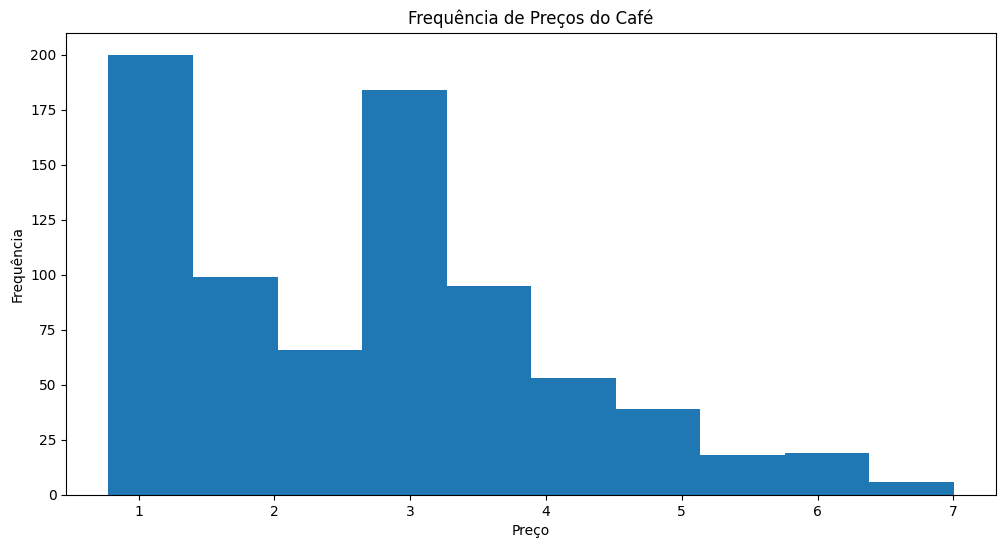

In [314]:
# Frequência de Preços do Café
plt.figure(figsize=(12, 6))
plt.hist(df['price'])
plt.title('Frequência de Preços do Café')
plt.xlabel('Preço')
plt.ylabel('Frequência')
plt.show()

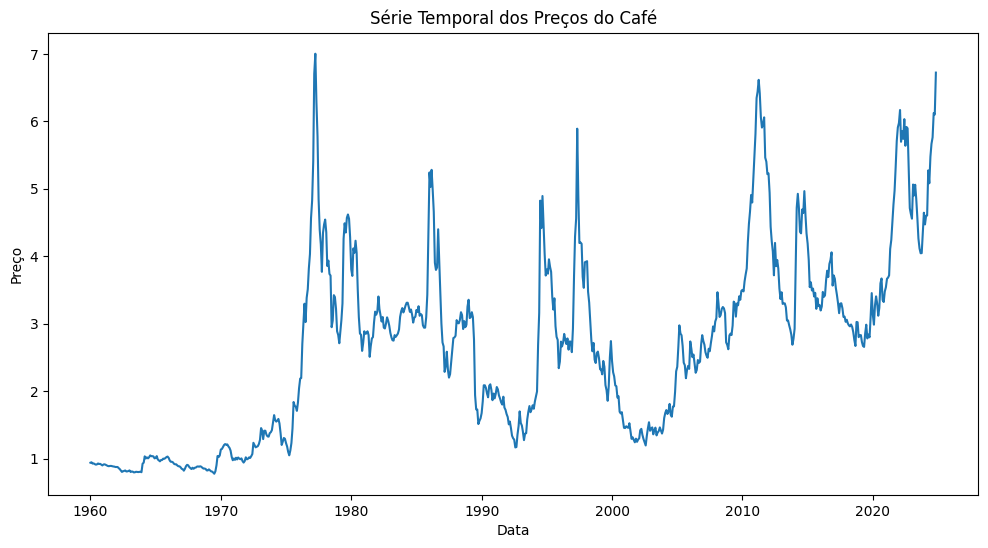

In [315]:
plt.figure(figsize=(12, 6))
plt.plot(df['price'])
plt.title('Série Temporal dos Preços do Café')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.show()

In [316]:
def dectect_outliers(df, threshold=3):
    """
    Detecta outliers no dataframe utilizando z-score
    """
    z_scores = np.abs(stats.zscore(df['price']))
    outliers = df[(z_scores > threshold)]
    return outliers
    
dectect_outliers(df, threshold=3)

,price,year
date,,
1977-04-01,7.0036,1977


3. Análise de tendências

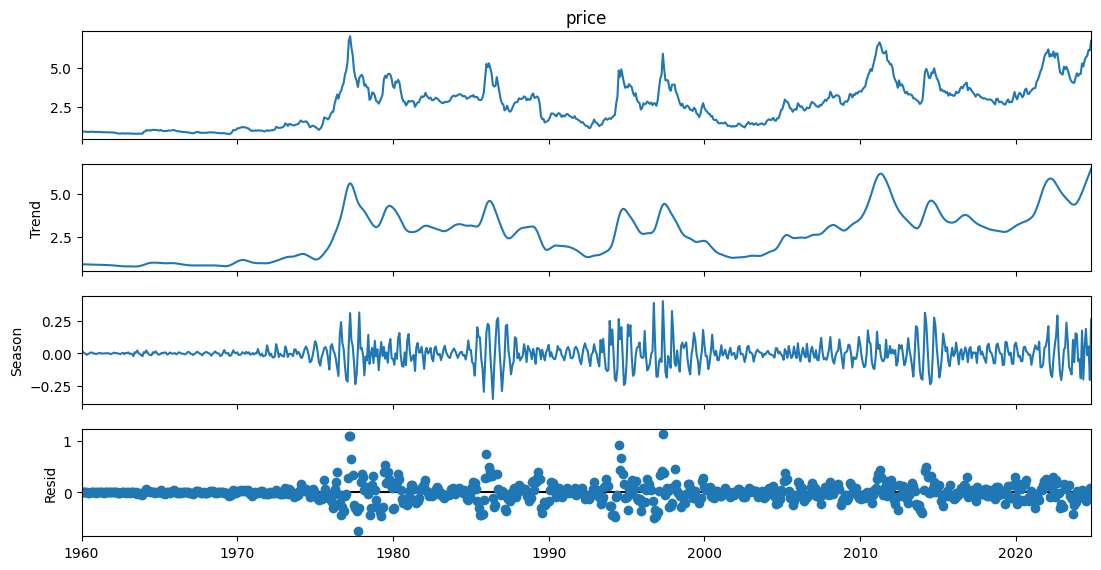

In [317]:
stl = STL(df['price'], period=7)

result = stl.fit()


fig = result.plot()
fig.set_size_inches(12, 6)
plt.show()


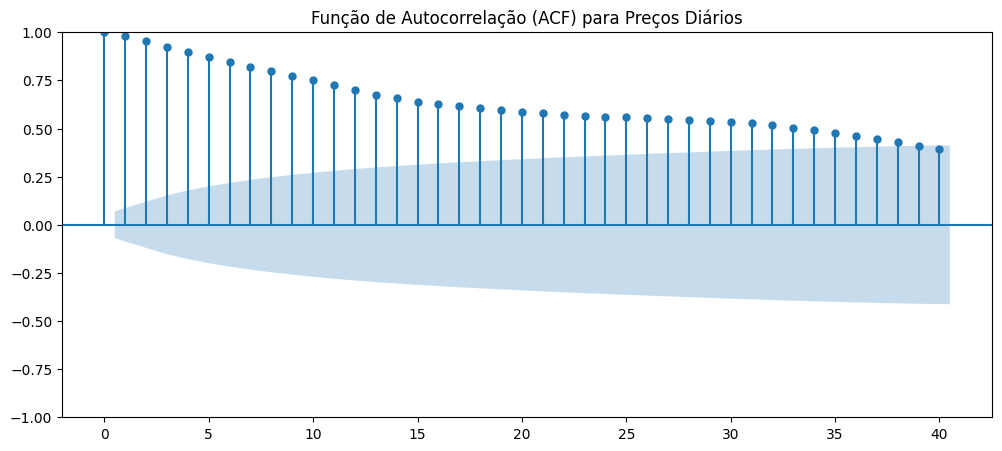

In [318]:
# Grafico de autocorrelação (ACF)
fig, ax = plt.subplots(figsize=(12, 5))
plot_acf(df['price'], lags=40, ax=ax)
ax.set_title('Função de Autocorrelação (ACF) para Preços Diários')
plt.show()

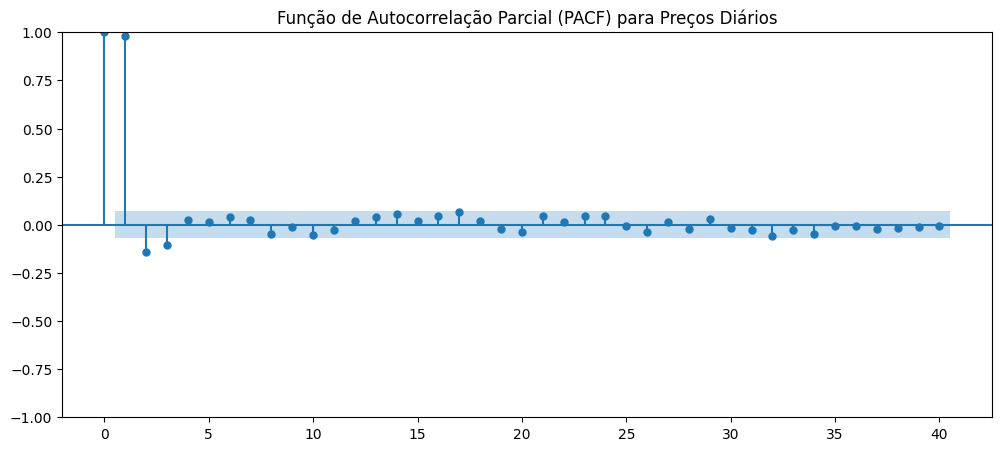

In [319]:
fig, ax = plt.subplots(figsize=(12, 5))
plot_pacf(df['price'], lags=40, ax=ax)
ax.set_title('Função de Autocorrelação Parcial (PACF) para Preços Diários')
plt.show()

In [320]:
def adf_test(df):
    """
    Realiza o teste ADF para verificar a estacionaridade da série temporal
    """
    result = adfuller(df['price'])
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])
    
    if result[1] <= 0.05:
        print("A série é estacionária")
    else:
        print("A série não é estacionária")

adf_test(df)

ADF Statistic: -1.6632196732946474
p-value: 0.4501554269939486
Critical Values: {'1%': np.float64(-3.4389608473398194), '5%': np.float64(-2.8653404270188476), '10%': np.float64(-2.568793735369693)}
A série não é estacionária


In [321]:
# Análise  de tendencia de longo prazo
def trend_analysis(df):
    """
    Realiza a análise de tendência da série temporal
    """
    # Define as janelas para as médias móveis
    windows = [7, 30, 90]
    # Cria um novo DataFrame para armazenar as médias, para não modificar o original
    rolling_means_df = pd.DataFrame(index=df.index)

    # Calcula a média móvel para cada janela
    for window in windows:
        col_name = f'MA_{window}'
        rolling_means_df[col_name] = df['price'].rolling(
            window=window, min_periods=1 # min_periods=1 para começar a calcular antes da janela completa
        ).mean()

    # Cria a figura e os eixos para o gráfico
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plota o preço original do DataFrame de entrada 'df'
    ax.plot(df.index, df['price'], label='Preço', alpha=0.7, color='grey')

    # Plota cada média móvel calculada (do rolling_means_df)
    for window in windows:
        col_name = f'MA_{window}'
        ax.plot(rolling_means_df.index, rolling_means_df[col_name],
                label=f'Média Móvel ({window} dias)') # Assume que os períodos são dias

    ax.set_title('Preços e Médias Móveis')
    ax.set_ylabel('Preço') 
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.6) # Adiciona uma grade para facilitar a leitura
    plt.tight_layout() # Ajusta o layout para evitar sobreposição

    return fig
    


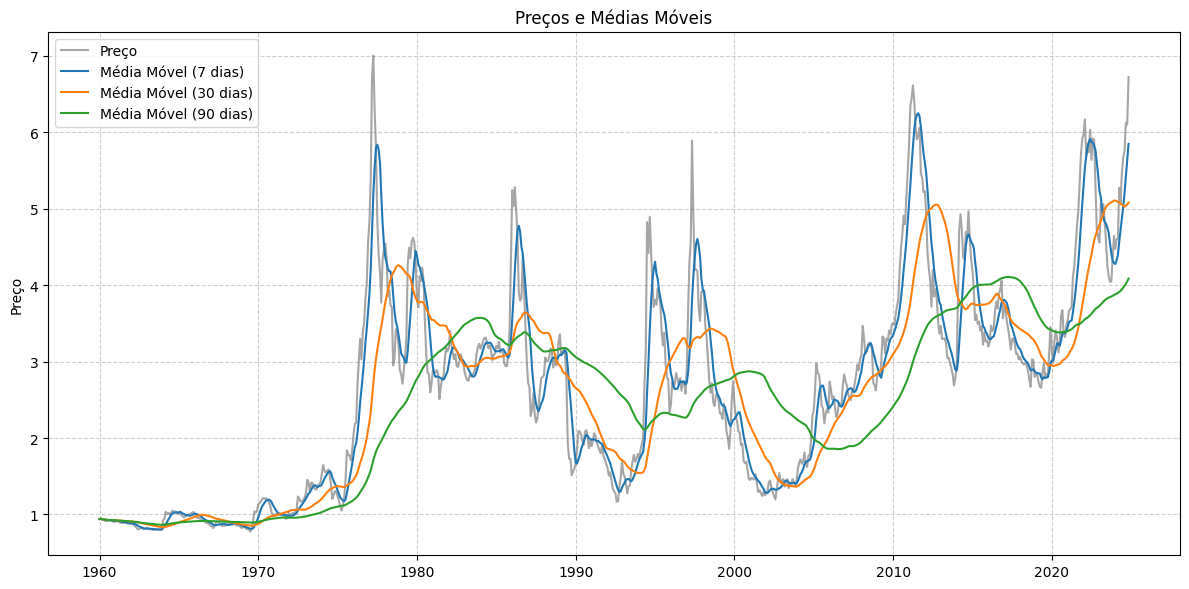

In [322]:
trend_analysis(df)
plt.show()

In [323]:
def seasonal_patterns(df):
        """Analisa padrões sazonais"""
        monthly_avg = df.groupby(df.index.month)['price'].mean()
        monthly_std = df.groupby(df.index.month)['price'].std()

        fig, ax = plt.subplots(figsize=(12, 6))
        monthly_avg.plot(kind='bar', yerr=monthly_std, ax=ax, color='skyblue', capsize=5)
        ax.set_title('Média Mensal de Preços com Desvio Padrão')
        ax.set_xlabel('Mês')
        ax.set_ylabel('Preço Médio')
        ax.set_xticklabels(['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun',
                            'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'], rotation=45)
        plt.tight_layout()
        plt.show()     
                
# crie a analoze para o padrao sazonal anual
# def seasonal_patterns_annual(df):
#       """Analisa padrões sazonais anuais"""
#      annual_avg = df.groupby(df.index.year)['price'].mean()
#     annual_std = df.groupby(df.index.year)['price'].std()
# 
#     fig, ax = plt.subplots(figsize=(12, 6))
#    annual_avg.plot(kind='bar', yerr=annual_std, ax=ax, color='skyblue', capsize=5)
#   ax.set_title('Média Anual de Preços com Desvio Padrão')
#   ax.set_xlabel('Ano')
#  ax.set_ylabel('Preço Médio')
#   ax.set_xticklabels(annual_avg.index, rotation=45)
# plt.tight_layout()
# plt.show()
#         

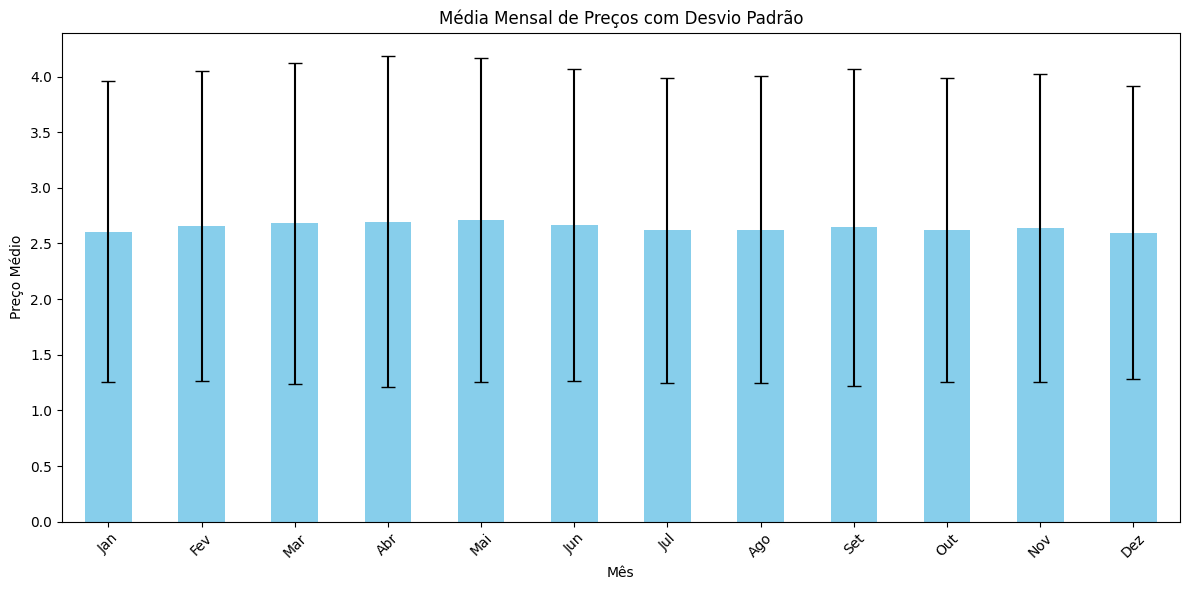

In [324]:
seasonal_patterns(df)

In [325]:
def seasonal_patterns_annual(df):
    """Analisa padrões sazonais anuais"""
    annual_avg = df.groupby(df.index.year)['price'].mean()
    annual_std = df.groupby(df.index.year)['price'].std()
 
    fig, ax = plt.subplots(figsize=(12, 6))
    annual_avg.plot(kind='bar', yerr=annual_std, ax=ax, color='skyblue', capsize=5)
    ax.set_title('Média Anual de Preços com Desvio Padrão')
    ax.set_xlabel('Ano')
    ax.set_ylabel('Preço Médio')
    ax.set_xticklabels(annual_avg.index, rotation=45)
    plt.tight_layout()
    plt.show()

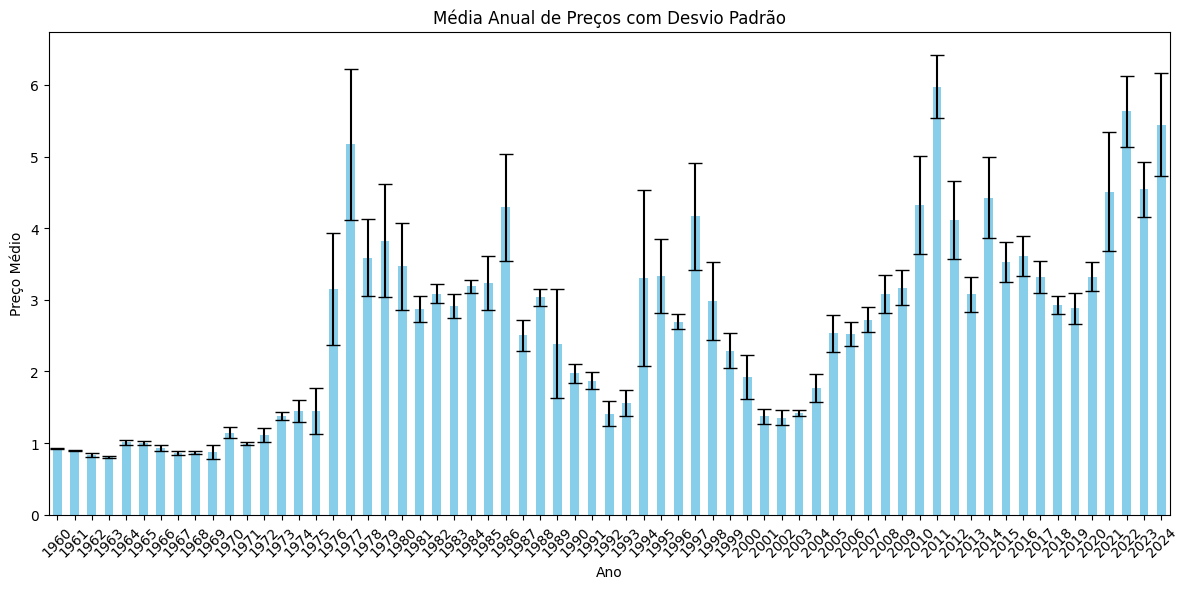

In [326]:
seasonal_patterns_annual(df)